# 評価方法

分類されていないデータを認識し、どれだけ正しくカテゴリごとに分類できるかを算出した「平均精度」の高さを競い合います。

今回、活用するデータはLSWMD_25519となります。
LSWMD_25519のFailureType項目が分類されていない状態のデータに対し、正しいFailureTypeカテゴリを分類するプログラムを作成し、その平均精度を算出します。
平均精度とは、カテゴリごとに正しく分類できる精度を平均した値です。カテゴリごとに算出した精度（Aが正しく分類された数/Aのデータ数）を足し、カテゴリ数で割ります。

公平な評価を実施するために、以下の制限を設けています。
1. 外部パッケージをインストールするためのセルとsolution関数の中身のみを編集すること
2. 校舎のiMac上で最後のセルの実行時間が15分未満であること　（%%timeitの出力結果を確認してください）

※気になる点がある場合、Discordで気軽にお問合せください。

In [1]:
import numpy as np # https://numpy.org/ja/
import pandas as pd # https://pandas.pydata.org/
from sklearn.model_selection import train_test_split

外部パッケージを使用する場合、以下の方法でインストールを実施してください。

In [2]:
# 必要な外部パッケージは、以下の内容を編集しインストールしてください
# !pip install keras
# !pip install tensorflow[and-cuda]
!pip install tensorflow
!pip install Pillow

以下のsolution関数のみ編集してください。

In [3]:

def show_img(image):
    import matplotlib.pyplot as plt
    import numpy as np
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

def solution(x_test_df, train_df):
    import tensorflow as tf
    import numpy as np
    from PIL import Image

    failure_types = list(train_df['failureType'].unique())
    # 大きさを統一
    normalized_train_maps = np.array([np.asarray(Image.fromarray(x).resize((64,64))) for x in train_df['waferMap'] / 2.0])
    train_labels = np.array([failure_types.index(x) for x in train_df['failureType']])
    show_img(normalized_train_maps[0])

    model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(64, 64)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(failure_types))
    ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    model.fit(normalized_train_maps, train_labels, epochs=10)
    model.fit(np.rot90(normalized_train_maps, k=1, axes=(1, 2)), train_labels, epochs=10)
    model.fit(np.rot90(normalized_train_maps, k=2, axes=(1, 2)), train_labels, epochs=10)
    model.fit(np.rot90(normalized_train_maps, k=3, axes=(1, 2)), train_labels, epochs=10)
    probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
    normalized_test_maps = np.array([np.asarray(Image.fromarray(x).resize((64,64))) for x in x_test_df['waferMap'] / 2.0])
    test_index = [x for x in x_test_df['waferIndex']]
    predictions = probability_model.predict(normalized_test_maps)
    answer = [failure_types[x.argmax()] for x in predictions]
    return pd.DataFrame({'failureType': answer}, index=x_test_df.index)


solution関数は以下のように活用され、平均精度を計算します。

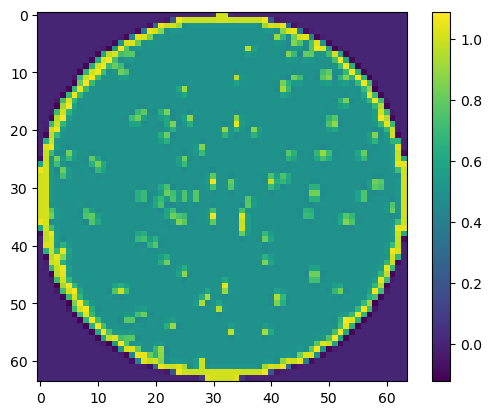

Epoch 1/10


2023-11-11 16:51:26.686839: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 376291328 exceeds 10% of free system memory.


718/718 [==============================] - 6s 7ms/step - loss: 0.8063 - accuracy: 0.7168
Epoch 2/10
718/718 [==============================] - 5s 7ms/step - loss: 0.6103 - accuracy: 0.7806
Epoch 3/10
718/718 [==============================] - 6s 8ms/step - loss: 0.5494 - accuracy: 0.8023
Epoch 4/10
718/718 [==============================] - 6s 8ms/step - loss: 0.5154 - accuracy: 0.8136
Epoch 5/10
718/718 [==============================] - 5s 7ms/step - loss: 0.4948 - accuracy: 0.8193
Epoch 6/10
718/718 [==============================] - 5s 7ms/step - loss: 0.4738 - accuracy: 0.8242
Epoch 7/10
718/718 [==============================] - 5s 7ms/step - loss: 0.4561 - accuracy: 0.8278
Epoch 8/10
718/718 [==============================] - 4s 5ms/step - loss: 0.4340 - accuracy: 0.8375
Epoch 9/10
718/718 [==============================] - 4s 5ms/step - loss: 0.4250 - accuracy: 0.8391
Epoch 10/10
718/718 [==============================] - 4s 5ms/step - loss: 0.4087 - accuracy: 0.8438
Epoch 1/10

2023-11-11 16:52:15.440473: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 376291328 exceeds 10% of free system memory.


718/718 [==============================] - 4s 5ms/step - loss: 0.5280 - accuracy: 0.8041
Epoch 2/10
718/718 [==============================] - 4s 5ms/step - loss: 0.4658 - accuracy: 0.8230
Epoch 3/10
718/718 [==============================] - 4s 5ms/step - loss: 0.4329 - accuracy: 0.8353
Epoch 4/10
718/718 [==============================] - 4s 5ms/step - loss: 0.4145 - accuracy: 0.8412
Epoch 5/10
718/718 [==============================] - 4s 5ms/step - loss: 0.4072 - accuracy: 0.8458
Epoch 6/10
718/718 [==============================] - 4s 5ms/step - loss: 0.3882 - accuracy: 0.8494
Epoch 7/10
718/718 [==============================] - 4s 5ms/step - loss: 0.3849 - accuracy: 0.8513
Epoch 8/10
718/718 [==============================] - 4s 5ms/step - loss: 0.3606 - accuracy: 0.8611
Epoch 9/10
718/718 [==============================] - 4s 5ms/step - loss: 0.3633 - accuracy: 0.8591
Epoch 10/10
718/718 [==============================] - 4s 6ms/step - loss: 0.3390 - accuracy: 0.8675
Epoch 1/10

2023-11-11 16:52:53.889801: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 376291328 exceeds 10% of free system memory.


718/718 [==============================] - 4s 5ms/step - loss: 0.4482 - accuracy: 0.8266
Epoch 2/10
718/718 [==============================] - 4s 5ms/step - loss: 0.3977 - accuracy: 0.8453
Epoch 3/10
718/718 [==============================] - 4s 5ms/step - loss: 0.3724 - accuracy: 0.8535
Epoch 4/10
718/718 [==============================] - 4s 5ms/step - loss: 0.3652 - accuracy: 0.8600
Epoch 5/10
718/718 [==============================] - 4s 5ms/step - loss: 0.3590 - accuracy: 0.8588
Epoch 6/10
718/718 [==============================] - 4s 5ms/step - loss: 0.3430 - accuracy: 0.8660
Epoch 7/10
718/718 [==============================] - 4s 6ms/step - loss: 0.3369 - accuracy: 0.8684
Epoch 8/10
718/718 [==============================] - 4s 6ms/step - loss: 0.3307 - accuracy: 0.8692
Epoch 9/10
718/718 [==============================] - 4s 5ms/step - loss: 0.3184 - accuracy: 0.8757
Epoch 10/10
718/718 [==============================] - 4s 5ms/step - loss: 0.3178 - accuracy: 0.8743
Epoch 1/10

2023-11-11 16:53:32.980393: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 376291328 exceeds 10% of free system memory.


718/718 [==============================] - 4s 6ms/step - loss: 0.4179 - accuracy: 0.8362
Epoch 2/10
718/718 [==============================] - 4s 6ms/step - loss: 0.3770 - accuracy: 0.8520
Epoch 3/10
718/718 [==============================] - 4s 6ms/step - loss: 0.3561 - accuracy: 0.8584
Epoch 4/10
718/718 [==============================] - 4s 5ms/step - loss: 0.3463 - accuracy: 0.8626
Epoch 5/10
718/718 [==============================] - 4s 6ms/step - loss: 0.3357 - accuracy: 0.8652
Epoch 6/10
718/718 [==============================] - 4s 6ms/step - loss: 0.3305 - accuracy: 0.8693
Epoch 7/10
718/718 [==============================] - 4s 6ms/step - loss: 0.3239 - accuracy: 0.8706
Epoch 8/10
718/718 [==============================] - 4s 5ms/step - loss: 0.3096 - accuracy: 0.8770
Epoch 9/10
718/718 [==============================] - 4s 5ms/step - loss: 0.3092 - accuracy: 0.8776
Epoch 10/10
80/80 [==============================] - 0s 2ms/step
平均精度：71.77%
2min 52s ± 0 ns per loop (mean ± s

In [4]:
%%timeit -r 1 -n 1

# データのインポート
df=pd.read_pickle("../input/LSWMD_25519.pkl")

# テスト用と学習用のデータを作成（テストする際は、random_stateの値などを編集してみてください）
train_df, test_df = train_test_split(df, stratify=df['failureType'], test_size=0.10, random_state=42)

y_test_df = test_df[['failureType']]
x_test_df = test_df.drop(columns=['failureType'])

# solution関数を実行
user_result_df = solution(x_test_df, train_df)

average_accuracy = 0
# ユーザーの提出物のフォーマット確認
if type(y_test_df) == type(user_result_df) and y_test_df.shape == user_result_df.shape:
    # 平均精度の計算
    accuracies = {}
    for failure_type in df['failureType'].unique():
        y_test_df_by_failure_type = y_test_df[y_test_df['failureType'] == failure_type]
        user_result_df_by_failure_type = user_result_df[y_test_df['failureType'] == failure_type]
        matching_rows = (y_test_df_by_failure_type == user_result_df_by_failure_type).all(axis=1).sum()
        accuracies[failure_type] = (matching_rows/(len(y_test_df_by_failure_type)))
    
    average_accuracy = sum(accuracies.values())/len(accuracies)

print(f"平均精度：{average_accuracy*100:.2f}%")